# Práctica 5: Regresión lineal regularizada: sesgo y varianza
### Aprendizaje Automático, Universidad Complutense de Madrid


- **Eladia Gómez Morales**
- **Ana Martínez Sabiote**

## Introducción

La práctica a desarrollar tiene como objetivo comprobar los efectos del sesgo y la varianza. Vamos a aplicar regresión lineal regularizada para aprender una hipótesis sesgada. Posteoriormente , vamos a aplicar regresión lineal para sobre-ajustar los datos de entrenamiento a un polinomio de grado 8. También presentaremos las curvas de aprendizaje obtenidas, que se utilizan cuando el número de atributos de los ejemplos es mayor y permiten identificar situaciones de underfitting y overfitting como las que nos interesan en esta práctica.

Para la realización de esta práctica utilizamos las librerías especificadas a continuación:

In [3]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt

## Ejercicio 1: Regresión lineal regularizada

Para cargar los datos del fichero proporcionado, utilizamos la función loadmat de scipy, ya que los casos de entrenamiento están en el formato nativo para matrices de Octave/Matlab. El diccionario resultante de la carga incluye las claves: X e y, con los datos de entrenamiento y Xval e yval con los ejemplos de validación.

In [4]:
mat = loadmat('ex5data1.mat')
X = mat.get("X")
y = mat.get("y")
Xval = mat.get("Xval")
yval = mat.get("yval")

print(X.shape, y.shape)
print(Xval.shape, yval.shape)
print(np.mean(X), np.std(X))
print(np.mean(y), np.std(y))

(12, 1) (12, 1)
(21, 1) (21, 1)
-5.085426348834809 28.68873075847896
11.217589325366376 12.492955274415026


In [5]:
def coste_vec(Theta, X, y):   
    H = np.dot(X, Theta)
    #H = np.dot(Theta, X)
    Aux = (H - y) ** 2
    return Aux.sum() / (2 * len(X))

In [6]:
def coste_reg(Theta, X, y, Lambda):
    Theta = Theta.reshape((Theta.shape[0],1))
    Term1 = coste_vec(Theta, X, y)
    Term2 = (Lambda/(2*len(y))) * np.sum(Theta**2)
    cost = Term1 + Term2
    return cost 

In [7]:
def gradiente_vec(theta, X, y):
    m = len(y)
    h = np.matmul(X, theta[:, None])
    err = (np.sum((h - y) ** 2)) / (2 * m)
    return err

In [8]:
def gradiente_reg(Theta, X, Y, Lambda):
    Theta = Theta.reshape((Theta.shape[0],1))
    item1 = gradiente_vec(Theta, X, Y).T
    item2  = (Lambda/len(y))*np.r_[[np.zeros(Theta.shape[1])], Theta[1:]]
    #item2  = (Lambda/len(y))*np.r_[[0], Theta[1:]]
    grad = item1 + item2
    grad = grad.flatten()
    return grad

In [9]:
def coste_grad_reg(theta, X, y, Lambda):
    m = len(y)
    # Make theta 2-d to get cost and gradient
    h = np.matmul(X, theta[:, None])

    tt = np.copy(theta)
    tt[0] = 0
    cost = (np.sum((h - y) ** 2)) / (2 * m) + (Lambda / (2 * m)) * np.sum(tt ** 2)
    gradients = (np.sum((h - y) * X, axis=0) / m) + (Lambda / m) * tt

    return (cost, gradients)

In [10]:
#theta = np.ones((2,1))
theta = np.ones(2)
m=len(y)
X_1 = np.hstack([np.ones([m, 1]), X])
coste, grad = coste_grad_reg(theta, X_1, y, 1)
print(coste, grad)

303.9931922202643 [-15.30301567 598.25074417]


In [11]:
print(X_1.shape)
print(theta.shape)

(12, 2)
(2,)


In [12]:
Lambda = 0
theta = np.ones((2,1))
#result = opt.fmin_tnc(func=coste_reg, x0=theta, fprime=gradiente_reg, args=(X_1,y,Lambda))
res = opt.minimize(fun=coste_grad_reg,  x0=theta,  args=(X_1,y,Lambda),  jac=True,   method='TNC',  options={'maxiter':400,'disp':False})

#Theta_opt=result[0]
Theta_opt = res.x
coste_opt = coste_reg(Theta_opt, X_1, y, Lambda)
print('Coste = {}'.format(coste_opt))

Coste = 22.373906495109022


In [13]:
print(Theta_opt.shape)

(2,)


In [14]:
def plot_H(X, Y, theta):
    plt.plot(X, Y, "x")
    theta0 = theta[0]
    theta1 = theta[1]
    min_x = min(X)
    max_x = max(X)
    min_y = theta0 + theta1 * min_x
    max_y = theta0 + theta1 * max_x
    plt.plot([min_x, max_x], [min_y, max_y])
    plt.savefig("resultado.pdf")

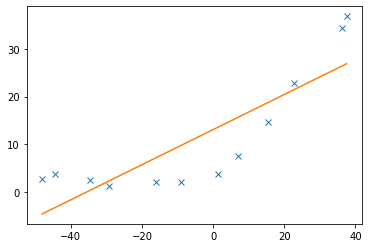

In [15]:
plot_H(X, y, Theta_opt)

## Ejercicio 2: Curvas de aprendizaje

In [16]:
def curva_aprendizaje(theta, X, y, Lambda):
    m = len(y)
    X_1 = np.hstack([np.ones([m, 1]), X])
    muestras, J_train, J_val = [], [], []
    for i in range(1, 11, 1):
        X_train_aux = X_1[:i, :]
        y_train_aux = y[:i]
        
        #result = opt.fmin_tnc(func=coste_reg, x0=theta, fprime=gradiente_reg, args=(X_train_aux,y_train_aux,Lambda))
        res = opt.minimize(fun=coste_grad_reg,  x0=theta,  args=(X_train_aux,y_train_aux,Lambda),  jac=True,   method='TNC',  options={'maxiter':400,'disp':False})
        theta_aux = res.x
        theta_aux = theta_aux.reshape((theta_aux.shape[0],1))
        J_train.append(coste_vec(theta_aux,X_train_aux,y_train_aux))
        J_val.append(coste_vec(theta_aux, X_1, y))
        muestras.append(y_train_aux.shape[0])
    return muestras, J_train, J_val

In [17]:
def plot_curva(muestras, J_train, J_val):
    plt.figure()
    plt.plot(muestras, J_train, label='Train')
    plt.plot(muestras, J_val, label='Cross Validation')
    plt.legend()
    plt.title('Learning curve for linear regression')
    plt.xlabel('Number of training examples')
    plt.ylabel('Error')
    plt.show()

In [18]:
print(X)
print(X.shape)

[[-15.93675813]
 [-29.15297922]
 [ 36.18954863]
 [ 37.49218733]
 [-48.05882945]
 [ -8.94145794]
 [ 15.30779289]
 [-34.70626581]
 [  1.38915437]
 [-44.38375985]
 [  7.01350208]
 [ 22.76274892]]
(12, 1)


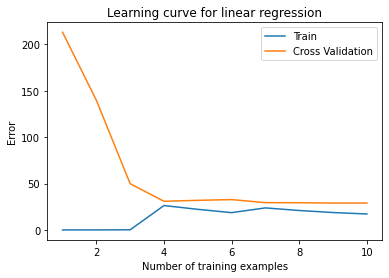

In [19]:
muestras, J_train, J_val = curva_aprendizaje(theta, Xval, yval, 0)
plot_curva(muestras, J_train, J_val)

## Ejercicio 3: Regresión polinomial

In [20]:
def expand_X(X, p):
    m=X.shape[0]
    X_p = np.zeros((m,p))
    for i in range(p):
        dim = i+1
        X_p[:, i] = X[:, 0] ** (i + 1)
 
    return X_p
    

In [21]:
X_8 = expand_X(X,8)

In [22]:
print(X_8)
print(X_8.shape)

[[-1.59367581e+01  2.53980260e+02 -4.04762197e+03  6.45059724e+04
  -1.02801608e+06  1.63832436e+07 -2.61095791e+08  4.16102047e+09]
 [-2.91529792e+01  8.49896197e+02 -2.47770062e+04  7.22323546e+05
  -2.10578833e+07  6.13900035e+08 -1.78970150e+10  5.21751305e+11]
 [ 3.61895486e+01  1.30968343e+03  4.73968522e+04  1.71527069e+06
   6.20748719e+07  2.24646160e+09  8.12984311e+10  2.94215353e+12]
 [ 3.74921873e+01  1.40566411e+03  5.27014222e+04  1.97589159e+06
   7.40804977e+07  2.77743990e+09  1.04132297e+11  3.90414759e+12]
 [-4.80588295e+01  2.30965109e+03 -1.10999128e+05  5.33448815e+06
  -2.56369256e+08  1.23208064e+10 -5.92123532e+11  2.84567638e+13]
 [-8.94145794e+00  7.99496701e+01 -7.14866612e+02  6.39194974e+03
  -5.71533498e+04  5.11034273e+05 -4.56939146e+06  4.08570215e+07]
 [ 1.53077929e+01  2.34328523e+02  3.58705250e+03  5.49098568e+04
   8.40548715e+05  1.28669456e+07  1.96964539e+08  3.01509237e+09]
 [-3.47062658e+01  1.20452489e+03 -4.18045609e+04  1.45088020e+06
  -

In [23]:
def normalizer(X):
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)
    X_norm = (X-mu)/sigma
    return X_norm, mu, sigma

In [24]:
X_8_norm, mu, sigma = normalizer(X_8)
print(X_8_norm)
print(X_8_norm.shape)

[[-3.78243704e-01 -7.88662325e-01  1.90328720e-01 -7.37591303e-01
   3.20251970e-01 -6.17151602e-01  3.59835014e-01 -5.31091256e-01]
 [-8.38920100e-01  1.31420204e-03 -2.58961742e-01 -3.41564822e-01
   9.75492734e-02 -4.55196644e-01  2.66773432e-01 -4.68873807e-01]
 [ 1.43871736e+00  6.10831582e-01  1.30534069e+00  2.56220001e-01
   1.02186338e+00 -1.26962121e-02  7.90210009e-01 -1.77926980e-01]
 [ 1.48412330e+00  7.38068463e-01  1.42031240e+00  4.13121830e-01
   1.15534830e+00  1.31223708e-01  9.10700224e-01 -6.22895388e-02]
 [-1.49791929e+00  1.93643966e+00 -2.12774745e+00  2.43510061e+00
  -2.51876748e+00  2.71792174e+00 -2.76331690e+00  2.88908182e+00]
 [-1.34409278e-01 -1.01936614e+00  2.62563148e-01 -7.72577738e-01
   3.31046537e-01 -6.21453712e-01  3.61188658e-01 -5.31586524e-01]
 [ 7.10844248e-01 -8.14713668e-01  3.55803314e-01 -7.43368461e-01
   3.41027665e-01 -6.18104683e-01  3.62252117e-01 -5.31229003e-01]
 [-1.03249041e+00  4.71428060e-01 -6.28018432e-01  9.70487696e-02
  -

In [25]:
print(mu)
print(mu.shape)

print(sigma)
print(sigma.shape)

[-5.08542635e+00  8.48904834e+02 -1.28290173e+04  1.28967789e+06
 -2.98314592e+07  2.29330301e+09 -6.84527284e+10  4.42233759e+12]
(8,)
[2.86887308e+01 7.54346385e+02 4.61380464e+04 1.66104441e+06
 8.99399404e+07 3.68940106e+09 1.89508052e+11 8.31905350e+12]
(8,)


In [26]:
#Añadimos columna de 1's a los datos de entrenamiento X_8_norm
m = X_8_norm.shape[0]
X_1 = np.hstack([np.ones([m, 1]), X_8_norm])

In [27]:
Lambda = 0
theta = np.ones((9,1))
#result = opt.fmin_tnc(func=coste_reg, x0=theta, fprime=gradiente_reg, args=(X_1,y,Lambda))
res = opt.minimize(fun=coste_grad_reg,  x0=theta,  args=(X_1,y,Lambda),  jac=True,   method='TNC',  options={'maxiter':400,'disp':False})
Theta_opt=res.x
coste_opt = coste_reg(Theta_opt, X_1, y, Lambda)
print('Coste = {}'.format(coste_opt))

Coste = 0.029030678442015633


In [28]:
print(Theta_opt)

[ 11.21762743   9.02353286  17.92171341  29.97248643 -25.74627755
 -77.25257421   3.57181392  62.93220802  22.99994942]


In [29]:
def plot_poli(X, y, theta, mu, sigma):
    plt.plot(X, y, "x")
    
    x1_min, x1_max = X[:, 0].min(), X[:, 0].max()
    xx1 = np.linspace(x1_min, x1_max)
    
    xx1=xx1.reshape((xx1.shape[0],1))
    
    theta=theta.reshape((theta.shape[0],1))
    
    X_8 = expand_X(xx1,8)
    
    X_8_norm = (X_8 - mu)/sigma
    X_8_norm_1 = np.hstack([np.ones([X_8_norm.shape[0], 1]), X_8_norm])

    
    h=0
    h = np.matmul(X_8_norm_1,theta)
        # 50x8 x 8, -> 50x1 -> 50,

    plt.plot(xx1, h)  
    plt.title('Polynomial regression (lambda = 0)')
    plt.xlabel('Change in water level (x)')
    plt.ylabel('Water lowing out of the dam (y)')
    plt.show()


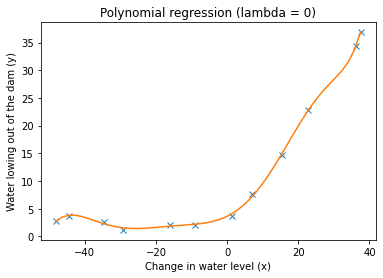

In [30]:
plot_poli(X, y, Theta_opt, mu, sigma)

In [31]:
def trainLinearReg(X, y, Lambda):
    initial_theta = np.zeros(np.size(X,1))
    #res = opt.fmin_tnc(func=coste_reg, x0=initial_theta, fprime=gradiente_reg, args=(X,y,Lambda))
    res = opt.minimize(fun=coste_grad_reg, x0=initial_theta, args=(X,y,Lambda), jac=True, method='TNC', options={'maxiter':400,'disp':False})
    return res.x

In [32]:
def curva_aprendizaje_poli(X, y, Xval, yval, Lambda):
    m_train = len(y)
    J_train = np.zeros(m_train)
    J_val = np.zeros(m_train)
    
    for i in range(1, m_train+1):
        theta_aux = trainLinearReg(X[0: i], y[0: i], Lambda)
        theta_aux = theta_aux.reshape((theta_aux.shape[0],1))
        J_train[i-1] = coste_vec(theta_aux, X[0: i], y[0: i])
        J_val[i-1] = coste_vec(theta_aux, Xval, yval)
        
    return (J_train, J_val)

In [33]:
X_8 = expand_X(X,8)
X_8_norm, mu, sigma = normalizer(X_8)
X_poly = np.hstack((np.ones_like(y), X_8_norm))

In [34]:
X_8_val = expand_X(Xval,8)
X_8_norm_val, mu, sigma = normalizer(X_8_val)
X_poly_val = np.hstack((np.ones_like(yval), X_8_norm_val))

In [35]:
#Curva de aprendizaje lAMBDA = 0
Lambda = 0.0
X_1 = np.hstack((np.ones_like(y), X_poly))
Xval_1 = np.hstack((np.ones_like(yval), X_poly_val))
#J_train, J_val = curva_aprendizaje_poli(X_poly, y, X_poly_val, yval, Lambda)
J_train, J_val = curva_aprendizaje_poli(X_1, y, Xval_1, yval, Lambda)

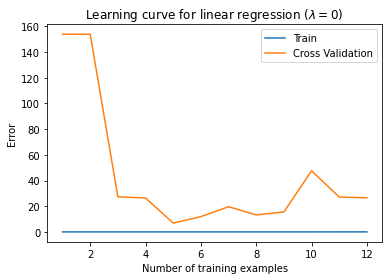

In [36]:
plt.figure()
plt.plot(range(1, len(X)+1), J_train, range(1, len(X)+1), J_val)
plt.title('Learning curve for linear regression ($\lambda = 0$)')
plt.legend(['Train', 'Cross Validation'])
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.savefig('learning curve (lambda = 0).pdf')
plt.show()

plt.close()

In [37]:
#Curva de aprendizaje lAMBDA = 1
Lambda = 1.0
#J_train, J_val = curva_aprendizaje_poli(X_poly, y, X_poly_val, yval, Lambda)
J_train, J_val = curva_aprendizaje_poli(X_1, y, Xval_1, yval, Lambda)

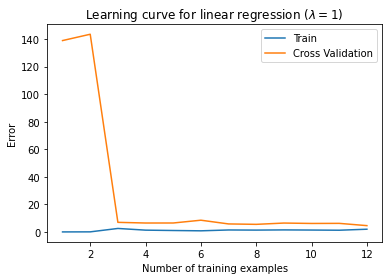

In [38]:
plt.figure()
plt.plot(range(1, len(X)+1), J_train, range(1, len(X)+1), J_val)
plt.title('Learning curve for linear regression ($\lambda = 1$)')
plt.legend(['Train', 'Cross Validation'])
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.savefig('learning curve (lambda = 0).pdf')
plt.show()

plt.close()

In [39]:
#Curva de aprendizaje lAMBDA = 100
Lambda = 100.0
#J_train, J_val = curva_aprendizaje_poli(X_poly, y, X_poly_val, yval, Lambda)
J_train, J_val = curva_aprendizaje_poli(X_1, y, Xval_1, yval, Lambda)

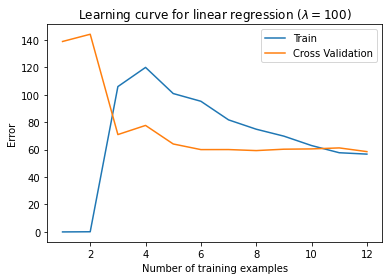

In [40]:
plt.figure()
plt.plot(range(1, len(X)+1), J_train, range(1, len(X)+1), J_val)
plt.title('Learning curve for linear regression ($\lambda = 100$)')
plt.legend(['Train', 'Cross Validation'])
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.savefig('learning curve (lambda = 0).pdf')
plt.show()

plt.close()

### Selección del parámetro Lambda

In [41]:
def validationCurve(X, y, Xval, yval):
    Lambdas = np.array([0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]).reshape((-1,1))
    error_train = np.zeros(len(Lambdas))
    error_val = np.zeros(len(Lambdas))
    
    for i in range(len(Lambdas)):
        reg = Lambdas[i]
        theta_aux = trainLinearReg(X, y, reg)
        theta_aux = theta_aux.reshape((theta_aux.shape[0],1))
        error_train[i] = coste_vec(theta_aux, X, y)
        error_val[i] = coste_vec(theta_aux, Xval, yval)
        
    return (Lambdas, error_train, error_val)

In [42]:
Lambdas, train, crossvalidation = validationCurve(X_poly, y, X_poly_val, yval)

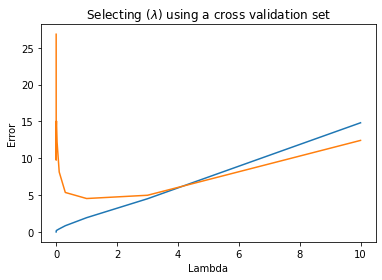

In [43]:
plt.figure()
plt.plot(Lambdas, train, label='Train')
plt.plot(Lambdas, crossvalidation, label='Cross validation')
plt.title('Selecting ($\lambda$) using a cross validation set')
plt.xlabel('Lambda')
plt.ylabel('Error')
plt.savefig('')
plt.show()

plt.close()

In [45]:
Xtest = mat.get("Xtest")
ytest = mat.get("ytest")

In [54]:
X = mat.get("X")
y = mat.get("y")

X_8_test = expand_X(Xtest,8)
X_norm_test, mu, sigma = normalizer(X_8_test)
"""
mu = np.mean(X, axis=0)
sigma = np.std(X, axis=0)
X_norm_test = (X_8_test-mu)/sigma
"""

X_poly_test = np.hstack((np.ones_like(ytest), X_norm_test))


Lambda_opt = 3
theta_test = trainLinearReg(X_poly_test, ytest, Lambda_opt)
error_test = coste_vec(theta_test, X_poly_test, ytest)
print(error_test)

3790.135876093158


In [55]:
print("Error sobre el conjunto de test para Lambda = 4:  {}".format(error_test))

Error sobre el conjunto de test para Lambda = 4:  3790.135876093158
